## Problem Set 3
**ECE 685D**: Deep Learning (Fall 2020) <br>
**Full name:** Guillem Amat Castello


<br>

### Problem 3: Binary Classification with Generalized Linear Models

In [159]:
# import packages 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pdb
import numpy as np
import pandas as pd 
import os

In [160]:
df = pd.read_csv('breast_cancer.csv')

In [161]:
""" data preparation """
# read csv file 
df = pd.read_csv('breast_cancer.csv')  # df denotes a data frame 

# extract the 'diagnosis' column as your targets 
targets = df['diagnosis']

# convert the entries of targets to 0/1 
targets = np.where(targets=='M', 0, 1)
     
# extract your features data
features = [column for column in df.columns if column not in ['id', 'diagnosis']]
data = np.array(df.loc[:, features].values)

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=40)

<br>

#### Problem 3.1
* #### __Important :__  You are not allowed to use built-in LDA functions from the sklearn package. 

In [174]:
class LDA:
    def _init_(self):
        pass
    
    def fit(self, X: np.array, y: np.array):
        #pdb.set_trace()
        
        X, y = np.array(X), np.array(y)
                
        c0, c1 = np.where(y==0, True, False), np.where(y==1, True, False)
        
        X0, X1 = X[c0, :], X[c1, :]
        y0, y1 = y[c0].reshape(1, -1)[0], y[c1].reshape(1, -1)[0]
        
        #Calculating priors
        self.pi0 =  X0.shape[0] / X.shape[0]
        self.pi1 =  X1.shape[0] / X.shape[0]
        
        #Calculating mean vectors
        self.M0, self.M1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
        
        #Calculting common Covariance Matrix
        cov0 = np.dot((X0 - self.M0).T, (X0 - self.M0))
        cov1 = np.dot((X1 - self.M1).T, (X1 - self.M1))
        self.cov_total  = (cov0 + cov1)/(X.shape[0]-X.shape[1])
        
        self.cov_inv = np.linalg.inv(self.cov_total)
    
    def delta(self, X: np.array, mean_vector: np.array, prior: float):
        '''Delta calculation for different classes'''
        delta = (np.dot(np.dot(X, self.cov_inv), mean_vector) - 
                 0.5 * np.dot(np.dot(mean_vector, self.cov_inv), mean_vector) + 
                 np.log(prior))
        return   delta
    
    def predict(self, X: np.array):
        #pdb.set_trace()
        X = np.array(X)
        
        #Calculate deltas
        D0  = self.delta(X, self.M0, self.pi0)
        D1  = self.delta(X, self.M1, self.pi1)
        
        y_hat = np.argmax(np.column_stack((D0, D1)), axis=1)
        
        return y_hat

<br>

**Fitting the Class to the Data**

In [172]:
L = LDA()
L.fit(X_train, y_train)

<br>

**Measuring Loss and Accuracy**

Accuracy

In [179]:
# Accuracy Calculation
train_accuracy = (sum(L.predict(X_train) == y_train)/len(y_train)*100).round(2)
test_accuracy = (sum(L.predict(X_test) == y_test)/len(y_test)*100).round(2)
print(f'Train Accuracy: {train_accuracy}% \nTest Accuracy: {test_accuracy}%')

Train Accuracy: 92.46% 
Test Accuracy: 95.32%


<br>We will use the 0-1 Loss Function:

$\mathcal{L}(y, f(x)) \rightarrow I(y \neq \phi(x))$

In [194]:
#Loss Function
train_loss = sum(L.predict(X_train) != y_train)
test_loss = sum(L.predict(X_test) != y_test)
print(f'Train Loss: {train_loss} \nTest Loss: {test_loss}')

Train Loss: 30 
Test Loss: 8


<br>

#### Problem 3.2

In [15]:
torch.manual_seed(7)

<br>

**Importing Torch Packages**

In [4]:
# Torch packages
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

<BR>

**Logistic Regression Class**

In [139]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12,1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

In [140]:
# Initializing Logistic Regression
model = LogisticRegression()

In [141]:
# Choosing Loss Function
criterion = nn.BCELoss()

In [142]:
# Choosing Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

<br>

**Training Logistic Regression**

In [5]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [26]:
def accuracy(network_prediction, actual_values):
    #pdb.set_trace()
    accuracy = torch.sum(network_prediction == actual_values).item()/len(network_prediction)
    return accuracy

In [145]:
LR_train_accuracy = []
LR_train_losses = []
LR_test_accuracy = []
LR_test_losses = []

for i in tqdm(range(250)):
    with torch.no_grad():   
        # Propagating X_test forward
        y_hat_test = model(X_test.float())
        
        # Calculating and appending Cross Entropy Loss
        loss_test = criterion(y_hat_test, y_test.reshape(-1, 1).float())
        LR_test_losses.append(loss_test.item())
    
        # Calculating and appending accuracy
        test_result = y_hat_test.round()
        LR_test_accuracy.append(accuracy(test_result.reshape(-1,), y_test.reshape(-1,)))
      
    # Calculating Accuracy and Cross-Entropy on Train set
    optimizer.zero_grad()
    
    # Propagating X_train forward
    y_hat = model(X_train.float())
    
    loss_train = criterion(y_hat, y_train.reshape(-1, 1).float())
    LR_train_losses.append(loss_train.item())
    loss_train.backward()
    
    train_result = y_hat.round()
    LR_train_accuracy.append(accuracy(train_result.reshape(-1,), y_train.reshape(-1,)))
    
    optimizer.step()

<br>

**Plotting the Results**

[]

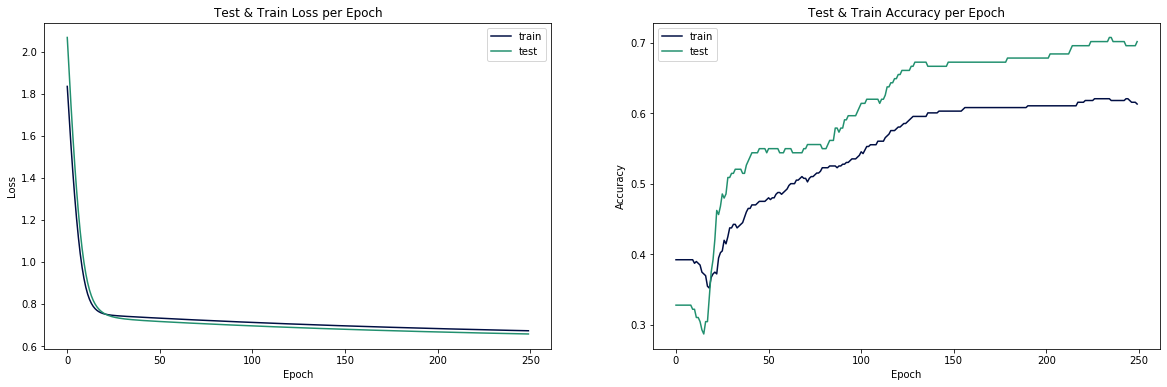

In [146]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

#Plotting accuracies
axes[0].plot(LR_train_losses, color='#000E43', label = 'train')
axes[0].plot(LR_test_losses, color='#22906F', label = 'test')
axes[0].set_title("Test & Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].plot()

#Plotting loss
axes[1].plot(LR_train_accuracy, color='#000E43', label = 'train')
axes[1].plot(LR_test_accuracy, color='#22906F', label = 'test')
axes[1].set_title("Test & Train Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].plot()

<br>

### Problem 4: Binary Classification with Neural Networks

#### 4.2 A Neural Network Class

**Creating Network**

In [101]:
torch.manual_seed(1)

In [102]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Linear(12, 16)
        self.hidden_1 = nn.Linear(16, 16)
        self.hidden_2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 2)
    
    def forward(self, x):
        x = torch.relu(self.initial(x))
        x = torch.relu(self.hidden_1(x))
        x = torch.relu(self.hidden_2(x))
        x = torch.sigmoid(self.output(x))
        return x

In [103]:
# Initializing the Neural Network
network = Net()

In [104]:
# Choosing Loss Function
criterion = nn.CrossEntropyLoss()

In [105]:
# Choosing optimizer
optimizer = torch.optim.SGD(network.parameters(), lr = 0.005)

<br>

**Training the Network**

In [106]:
train_accuracy = []
train_losses = []
test_accuracy = []
test_losses = []

for i in tqdm(range(14000)):
    #with torch.no_grad():   
    # Propagating X_test forward
    predictions = network(X_test.float())
    
    # Calculating and appending Cross Entropy Loss
    loss = criterion(predictions, y_test.long())
    test_losses.append(loss.item())
    
    # Calculating and appending accuracy
    test_result = torch.argmax(predictions, dim=1)
    test_accuracy.append(accuracy(test_result, y_test))
      
    # Calculating Accuracy and Cross-Entropy on Train set
    optimizer.zero_grad()
    
    # Propagating X_train forward
    y_hat = network(X_train.float())
    
    loss_train = criterion(y_hat, y_train.long())
    train_losses.append(loss_train.item())
    loss_train.backward()
    
    train_result = torch.argmax(y_hat, dim=1)
    train_accuracy.append(accuracy(train_result, y_train))
    
    optimizer.step()

[]

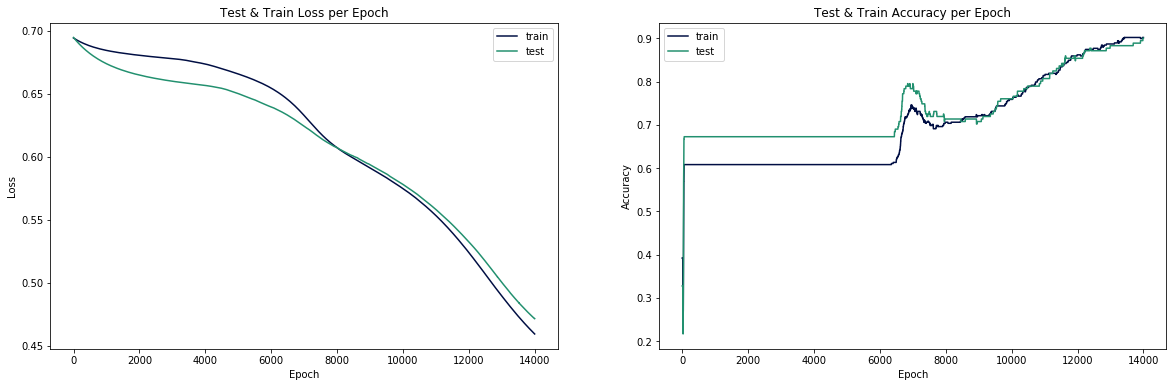

In [107]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

#Plotting accuracies
axes[0].plot(train_losses, color='#000E43', label = 'train')
axes[0].plot(test_losses, color='#22906F', label = 'test')
axes[0].set_title("Test & Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].plot()

#Plotting loss
axes[1].plot(train_accuracy, color='#000E43', label = 'train')
axes[1].plot(test_accuracy, color='#22906F', label = 'test')
axes[1].set_title("Test & Train Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].plot()

<br>

#### 4.2 B Neural Network Architecture

In [175]:
class MultipleNet(nn.Module):
    def __init__(self, input_size, N, M, output_size):
        super(MultipleNet, self).__init__()
        
        #Input Layer
        self.initial = nn.Linear(input_size, M, bias = False)
        
        #Flexible number of Layers
        self.hidden = nn.ModuleList([])
        self.hidden.extend([nn.Linear(M, M, bias = False) for n in range(N)])
        
        #Output Layer
        self.output = nn.Linear(M, output_size, bias = False)
        
    def forward(self, x):
        x = torch.relu(self.initial(x))
        
        #Propagating forward through flexible architecture
        h = x
        for i in range(len(self.hidden)):
            h = self.hidden[i](h)
            h = torch.relu(h)
        
        x = torch.sigmoid(self.output(h))
        
        return x 

In [149]:
# Testing MLP Architecture
MN = MultipleNet(12, 2, 2, 2)
print(MN)

MultipleNet(
  (initial): Linear(in_features=12, out_features=2, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
  )
  (output): Linear(in_features=2, out_features=2, bias=True)
)


<br>

**Create Initialization Function**

In [150]:
def initialize_net(input_layer:int, N:int, M:int, output_layer:int):
    #Initialize all Neural Net Objects
    Multiple_Net = MultipleNet(input_layer, N, M, output_layer)
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(Multiple_Net.parameters(), lr=0.005)
    return Multiple_Net, criterion, optimizer

<br>

**Create Train Function**

In [151]:
def train_net(Multiple_Net, criterion, optimizer, loops: int):
    for i in range(loops):
        optimizer.zero_grad()
        
        # Propagating X_train forward
        y_hat = Multiple_Net(X_train.float())
        
        loss = criterion(y_hat, y_train.long())
        loss.backward()
        
        optimizer.step() 

<br>

**Create Test Function**

In [152]:
def test_network(Multiple_Net, criterion):
    with torch.no_grad():
        # Load model
        Multiple_Net.eval()
    
        # Propagate the network forward
        y_hat = Multiple_Net(X_test.float())
        loss = criterion(y_hat, y_test.long())
    
        # Get predictions
        predictions = torch.argmax(y_hat, dim=1)
        
        return predictions

<br>

**Chaining Operations**

In [153]:
N = [1, 2, 3, 4, 5, 6, 7, 8]
M = [2, 4, 8, 16, 32, 64, 128]
accuracy_matrix = np.zeros((len(M), len(N)))

In [154]:
for i, n in enumerate(N):
    for j, m in enumerate(M):
        # Initializing Neural Net Object for (M, N)
        Multiple_Net, criterion, optimizer = initialize_net(12, n, m, 2)
        
        # Training (M, N) Network
        train_net(Multiple_Net, criterion, optimizer, 1000)
        
        loss.register_hook(lambda grad: print(grad))
        
        # Testing (M, N) Network and retrieving results
        accuracy_matrix[j, i] = accuracy(test_network(Multiple_Net, criterion), y_test.long())

<br>

**Plotting the Results**

In [155]:
from matplotlib.colors import ListedColormap
colormap = ListedColormap(['#66B57D','#44A373', '#22906F', '#007D6F',
                           '#00646F','#004261', '#002552', '#000E43'])

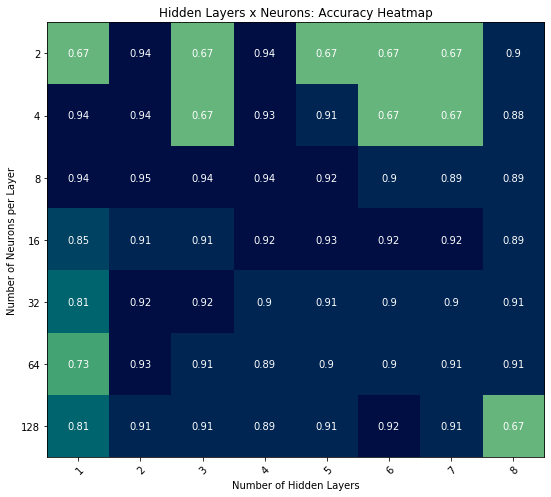

In [156]:
fig, ax = plt.subplots(figsize=(16,8))

plt.imshow(accuracy_matrix.round(2), cmap=colormap, interpolation='nearest')

ax.set_xticks(np.arange(len(N)))
ax.set_yticks(np.arange(len(M)))

ax.set_xticklabels(N)
ax.set_yticklabels(M)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(M)):
    for j in range(len(N)):
        text = ax.text(j, i, accuracy_matrix[i, j].round(2),
                       ha="center", va="center", color="w")

ax.set_title("Hidden Layers x Neurons: Accuracy Heatmap")
ax.set_xlabel('Number of Hidden Layers')
ax.set_ylabel('Number of Neurons per Layer')
plt.show()
#ax.colorbar()
plt.show()

- In some cases the Network seems to get stuck in local minima with a low accuracy score of 67%.
- In general it seems that having more hidden layers is positive, as long as there is a large enough value of neurons per layer.
- The worst results are found for small numbers of neurons per layer and for a small number of hidden layers. 

<br>

#### Problem 4.3
* #### __Important :__  Here, you are not allowed to use the Optim package. 

In [103]:
torch.manual_seed(42)

**Neural Network Class Definition**

In [104]:
class ManualNet:
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.initial = nn.Linear(12, 16)
        self.hidden1 = nn.Linear(16, 16)
        self.hidden2 = nn.Linear(16, 16)
        self.output  = nn.Linear(16, 1)
    
    def forward(self, x):
        L1  = self.initial(x)
        Z1  = torch.relu(L1)
        L2  = self.hidden1(Z1)
        Z2  = torch.relu(L2)
        L3  = self.hidden2(Z2)
        Z3  = torch.relu(L3)
        L4  = self.output(Z3)
        OUT = torch.sigmoid(L4)
        return L1, Z1, L2, Z2, L3, Z3, L4, OUT
    
    def backpropagate(self, X, Y):
        
        L1, Z1, L2, Z2, L3, Z3, L4, OUT = self.forward(X)
        
        with torch.no_grad():
            W2, W3, W4 = self.hidden1.weight, self.hidden2.weight, self.output.weight
            
            E     = OUT - Y.reshape(-1, 1)
            D4    = torch.matmul(Z3.T, E)
            G3    = torch.matmul(E, W4)
            R3    = torch.where(L3>=0, G3, torch.zeros(G3.shape))
            D3    = torch.matmul(Z2.T, R3)
            G2    = torch.matmul(R3, W3)
            R2    = torch.where(L2>=0, G2, torch.zeros(G2.shape))
            D2    = torch.matmul(Z1.T, R2)
            G1    = torch.matmul(R2, W2)
            R1    = torch.where(L1>=0, G1, torch.zeros(G1.shape))
            D1    = torch.matmul(X.T, R1)
            
            #pdb.set_trace()
            self.initial.weight -= self.lr * D1.T
            self.hidden1.weight -= self.lr * D2.T
            self.hidden2.weight -= self.lr * D3.T
            self.output.weight -= self.lr * D4.T
            
            return OUT

In [105]:
# Initializing Loss Function and Manual Neural Net
manual_net = ManualNet(lr = 0.00001)
criterion = nn.BCELoss()

In [108]:
manual_train_accuracy = []
manual_train_losses = []
manual_test_accuracy = []
manual_test_losses = []

for i in tqdm(range(4000)):
    #Test
    #pdb.set_trace()
    with torch.no_grad():
        predictions = manual_net.forward(X_test.float())[-1]
    
        loss = criterion(predictions.squeeze(), y_test.float())
        manual_test_losses.append(loss.item())
    
        manual_test_accuracy.append(accuracy(predictions.round().reshape(-1,), y_test.reshape(-1,)))
    
    #Train
    y_hat = manual_net.backpropagate(X_train, y_train)
    
    loss = criterion(y_hat.squeeze(), y_train)
    manual_train_losses.append(loss.item())
    
    manual_train_accuracy.append(accuracy(y_hat.round().reshape(-1,), y_train.reshape(-1,)))

**Plotting the Results of the Manual Neural Network**

[]

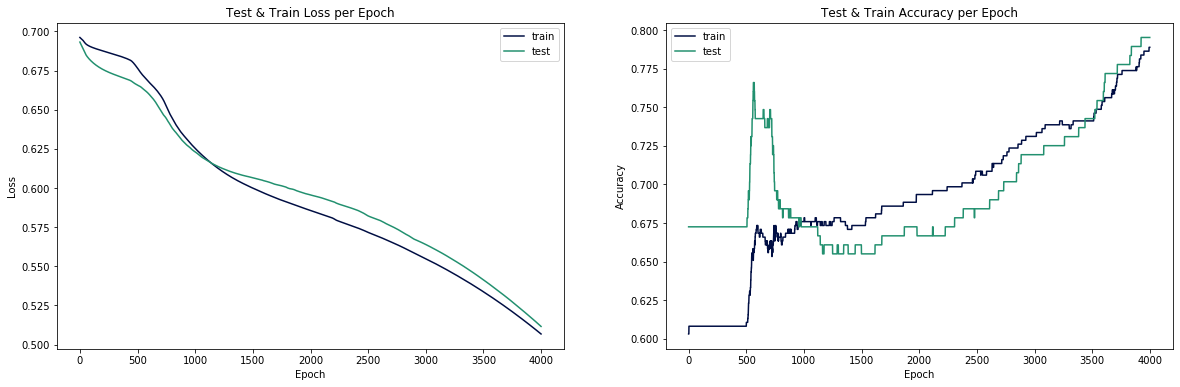

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

#Plotting accuracies
axes[0].plot(manual_train_losses, color='#000E43', label = 'train')
axes[0].plot(manual_test_losses, color='#22906F', label = 'test')
axes[0].set_title("Test & Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].plot()

#Plotting loss
axes[1].plot(manual_train_accuracy, color='#000E43', label = 'train')
axes[1].plot(manual_test_accuracy, color='#22906F', label = 'test')
axes[1].set_title("Test & Train Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].plot()

<br>

### Problem 5: First order optimization methods

In [5]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Download and prepare the MNIST data set 
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

"""
The data features can be extracted as train_dataset/test_dataset.data
The labels can be extracted as train_dataset/test_dataset.targets 
Note that the data are 28x28 images which you will have to transform to vectors.  
"""

'\nThe data features can be extracted as train_dataset/test_dataset.data\nThe labels can be extracted as train_dataset/test_dataset.targets \nNote that the data are 28x28 images which you will have to transform to vectors.  \n'

<br>

**Initializing Hyperparameters**

In [147]:
learning_rate = 0.001
batch_sizes   = [1, 500, 60000]
lambda_list   = [0.01, 0.1, 1]
i = 0

<br>

**Optimization Algorithm Classes**

In [95]:
#Momentum Network Class
class MomentumNetwork(nn.Module):
    def __init__(self):
        super(MomentumNetwork, self).__init__()
        self.layer = nn.Linear(28*28, 10)
        self.momentum      = 0
        self.beta          = 0.9
        
    def forward(self, x):
        x = self.layer(x)
        return x
    
    def step(self, gradient, learning_rate):
        with torch.no_grad():
            self.momentum = self.beta * self.momentum + gradient
            self.layer.weight -= learning_rate * self.momentum

In [84]:
#Nesterov's Accelerated Gradient
class NesterovNetwork(nn.Module):
    def __init__(self):
        super(NesterovNetwork, self).__init__()
        self.layer = nn.Linear(28*28, 10)
        self.beta  = 100
        self.ln    = 0
        self.t     = 0
        
    def forward(self, x):
        x = self.layer(x)
        return x
    
    def step(self, gradient, learning_rate):
        with torch.no_grad():
            #pdb.set_trace()
            ln2 = (1 + np.sqrt(1 + 4*self.ln**2))/2
            self.gamma = (1 - self.ln)/ln2
            t_k = self.layer.weight - learning_rate * gradient
            self.layer.weight = torch.nn.Parameter((1 - self.gamma) * t_k + self.gamma * self.t)
            self.ln = ln2
            self.t = t_k

In [113]:
#RMSProp
class RMSPropNetwork(nn.Module):
    def __init__(self):
        super(RMSPropNetwork, self).__init__()
        self.layer = nn.Linear(28*28, 10)
        self.beta = 0.9
        self.gamma = 1
        self.e = 10**(-8)
        self.k = torch.zeros(10, 28*28)
        self.v = torch.zeros(10, 28*28)
    
    def forward(self, x):
        x = self.layer(x)
        return x
    
    def step(self, gradient, learning_rate):
        #pdb.set_trace()
        with torch.no_grad():
            #pdb.set_trace()
            self.v = (1 - self.beta) * self.v +  (1 - self.beta) * (gradient**2)
            self.k = self.gamma* (1/(torch.sqrt(self.v + self.e)))
            self.layer.weight -= torch.nn.Parameter(learning_rate * self.k * gradient)

In [141]:
#Adam
class AdamNetwork(nn.Module):
    def __init__(self):
        super(AdamNetwork, self).__init__()
        self.layer = nn.Linear(28*28, 10)
        self.beta1  = 0.9
        self.beta2 = 0.999
        self.e     = 10**(-8)
        self.k     = 0
        self.m_1   = 0
        self.m_2   = 0
        
        
    def forward(self, x):
        x = self.layer(x)
        return x
    
    def step(self, gradient, learning_rate):
        with torch.no_grad():
            #pdb.set_trace()
            self.k += 1
            self.m_1 = self.beta1 * self.m_1 + (1 - self.beta1) * gradient
            m_1_debiased = self.m_1 * 1/(1 - (self.beta1**self.k))
            self.m_2 = self.beta2 * self.m_2 + (1 - self.beta2) * (gradient)**2
            m_2_debiased = self.m_2 * 1/(1 - (self.beta2**self.k))
            self.layer.weight -= torch.nn.Parameter(learning_rate * m_1_debiased / (self.e + torch.sqrt(m_2_debiased)))       

<br>

**Function to Evaluate Optimization Algorithms**

In [155]:
def optimization_algorithm_evaluation(name: str) -> str:
    
    print(name)
    i = 0
    
    for batch in batch_sizes:
        
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
        testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)
        
        for l in lambda_list:
            
            i += 1
            print(f'Iteration {i} -> Batch Size: {batch} | Lambda: {l}') 
            
            model = MomentumNetwork() #Change name of Network here when running
            criterion = nn.CrossEntropyLoss()
            
            if batch == 1:
                epochs = 3
            elif batch == 500:
                epochs = 10
            else:
                epochs = 10
            
            for epoch in range(epochs):
    
                for (X_train, y_train) in trainloader:    
                    
                    #Getting the data into the right format and making a pass forward
                    X_train = X_train.view(-1, 28*28)
                    train_predictions = model(X_train)
                    
                    #Calculating the Loss for a batch during training
                    loss = criterion(train_predictions, y_train)
                    loss.backward()
                    
                    #Taking a gradient step with Optimization Method
                    model.step(model.layer.weight.grad, l)
                   
                with torch.no_grad():
                    model.eval()
                    
                    total_loss = 0
                    n  = 0
                    
                    for X_test, y_test in testloader:
                        #Getting the data into the right format and making a pass forward     
                        X_test = X_test.view(-1, 28*28)
                        test_predictions = model(X_test)
                        
                        #Calculating Accuracy
                        prediction = torch.argmax(test_predictions, dim = 1)
                        n += torch.eq(prediction,torch.view_as(y_test, prediction)).sum().item()    
                        
                        #Calculating the Loss for a batch and suming it up
                        loss = criterion(test_predictions, y_test)
                        total_loss += (loss*batch)/len(testloader.dataset)                   
        
                #total_loss     = total_test_loss / len(testloader.dataset)
                total_accuracy =  (n / len(testloader.dataset)) * 100
                
                #Formatting printing results to align columns
                e = str(epoch + 1)
                if len(e) == 1:
                    e = e + ' '
                    pass
                
                #pdb.set_trace()
                if len(str(total_accuracy)) == 5:
                    pass
                elif len(str(total_accuracy)) < 5:
                    total_accuracy = str(total_accuracy) + '0'
                else:
                    total_accuracy = str(total_accuracy)[:5]
                
                print(f'Epoch: {e} | Accuracy: {total_accuracy}% | Loss: {torch.round(total_loss)}')
                total_loss = 0
            print('-'*50)

<br>

<br>

**Optimization Algorithms Results**

- Below you can find the result of applying the different optimization algorithms.
- Even though they all converge, there is something off with the loss. 
- The accuracy serves as an indicator that the model converges in all cases.

<br>

**Momentum Method**

In [156]:
optimization_algorithm_evaluation(name = 'Momentum Optimization Method')

Momentum Optimization Method
Iteration 1 -> Batch Size: 1 | Lambda: 0.01
Epoch: 1  | Accuracy: 88.27% | Loss: 36777.0
Epoch: 2  | Accuracy: 86.04% | Loss: 93032.0
Epoch: 3  | Accuracy: 87.67% | Loss: 128542.0
--------------------------------------------------
Iteration 2 -> Batch Size: 1 | Lambda: 0.1
Epoch: 1  | Accuracy: 87.49% | Loss: 432892.0
Epoch: 2  | Accuracy: 86.55% | Loss: 935195.0
Epoch: 3  | Accuracy: 87.22% | Loss: 1382426.0
--------------------------------------------------
Iteration 3 -> Batch Size: 1 | Lambda: 1
Epoch: 1  | Accuracy: 86.91% | Loss: 4912550.0
Epoch: 2  | Accuracy: 88.19% | Loss: 9796052.0
Epoch: 3  | Accuracy: 89.14% | Loss: 12890691.0
--------------------------------------------------
Iteration 4 -> Batch Size: 500 | Lambda: 0.01
Epoch: 1  | Accuracy: 80.16% | Loss: 6.0
Epoch: 2  | Accuracy: 63.27% | Loss: 95.0
Epoch: 3  | Accuracy: 60.06% | Loss: 246.0
Epoch: 4  | Accuracy: 54.51% | Loss: 416.0
Epoch: 5  | Accuracy: 62.31% | Loss: 527.0
Epoch: 6  | Acc

<br>

**Nesterov's Accelerated Gradient**

In [154]:
optimization_algorithm_evaluation(name = 'Nesterov\'s Optimization Method')

Nesterov's Optimization Method
Iteration 1 -> Batch Size: 1 | Lambda: 0.01
Epoch: 1  | Accuracy: 87.98% | Loss: 853.0
Epoch: 2  | Accuracy: 84.76% | Loss: 2683.0
Epoch: 3  | Accuracy: 84.07% | Loss: 3877.0
--------------------------------------------------
Iteration 2 -> Batch Size: 1 | Lambda: 0.1
Epoch: 1  | Accuracy: 84.64% | Loss: 10268.0
Epoch: 2  | Accuracy: 86.83% | Loss: 27017.0
Epoch: 3  | Accuracy: 85.26% | Loss: 34856.0
--------------------------------------------------
Iteration 3 -> Batch Size: 1 | Lambda: 1
Epoch: 1  | Accuracy: 84.30% | Loss: 134502.0
Epoch: 2  | Accuracy: 85.45% | Loss: 259990.0
Epoch: 3  | Accuracy: 85.83% | Loss: 344879.0
--------------------------------------------------
Iteration 4 -> Batch Size: 500 | Lambda: 0.01
Epoch: 1  | Accuracy: 88.28% | Loss: 0.0
Epoch: 2  | Accuracy: 90.66% | Loss: 0.0
Epoch: 3  | Accuracy: 91.40% | Loss: 0.0
Epoch: 4  | Accuracy: 91.88% | Loss: 0.0
Epoch: 5  | Accuracy: 92.04% | Loss: 0.0
Epoch: 6  | Accuracy: 92.11% | Lo

<br>

**RMSProp**

In [152]:
optimization_algorithm_evaluation(name = 'RMSProp Optimization Algorithm')

RMSProp Optimization Algorithm
Iteration 1 -> Batch Size: 1 | Lambda: 0.01
Epoch: 1  | Accuracy: 87.03% | Loss: 265.0
Epoch: 2  | Accuracy: 88.49% | Loss: 420.0
Epoch: 3  | Accuracy: 88.42% | Loss: 551.0
--------------------------------------------------
Iteration 2 -> Batch Size: 1 | Lambda: 0.1
Epoch: 1  | Accuracy: 86.64% | Loss: 2964.0
Epoch: 2  | Accuracy: 88.92% | Loss: 3847.0
Epoch: 3  | Accuracy: 89.03% | Loss: 5460.0
--------------------------------------------------
Iteration 3 -> Batch Size: 1 | Lambda: 1
Epoch: 1  | Accuracy: 88.03% | Loss: 26126.0
Epoch: 2  | Accuracy: 88.53% | Loss: 38257.0
Epoch: 3  | Accuracy: 88.61% | Loss: 49400.0
--------------------------------------------------
Iteration 4 -> Batch Size: 500 | Lambda: 0.01
Epoch: 1  | Accuracy: 89.94% | Loss: 1.0
Epoch: 2  | Accuracy: 90.31% | Loss: 1.0
Epoch: 3  | Accuracy: 89.25% | Loss: 1.0
Epoch: 4  | Accuracy: 89.91% | Loss: 1.0
Epoch: 5  | Accuracy: 89.70% | Loss: 1.0
Epoch: 6  | Accuracy: 89.52% | Loss: 1.0


<br>

**Adam**

In [149]:
optimization_algorithm_evaluation(name = 'ADAM Optimization Algorithm')

ADAM Optimization Algorithm
Iteration 1 -> Batch Size: 1 | Lambda: 0.01
Epoch: 1  | Accuracy: 88.92% | Loss: 223.0
Epoch: 2  | Accuracy: 88.73% | Loss: 319.0
Epoch: 3  | Accuracy: 88.86% | Loss: 353.0
--------------------------------------------------
Iteration 2 -> Batch Size: 1 | Lambda: 0.1
Epoch: 1  | Accuracy: 89.14% | Loss: 2179.0
Epoch: 2  | Accuracy: 88.71% | Loss: 3032.0
Epoch: 3  | Accuracy: 89.21% | Loss: 3642.0
--------------------------------------------------
Iteration 3 -> Batch Size: 1 | Lambda: 1
Epoch: 1  | Accuracy: 89.19% | Loss: 21861.0
Epoch: 2  | Accuracy: 88.70% | Loss: 29046.0
Epoch: 3  | Accuracy: 88.41% | Loss: 36657.0
--------------------------------------------------
Iteration 4 -> Batch Size: 500 | Lambda: 0.01
Epoch: 1  | Accuracy: 59.30% | Loss: 12.0
Epoch: 2  | Accuracy: 68.23% | Loss: 14.0
Epoch: 3  | Accuracy: 79.50% | Loss: 11.0
Epoch: 4  | Accuracy: 76.64% | Loss: 17.0
Epoch: 5  | Accuracy: 78.79% | Loss: 18.0
Epoch: 6  | Accuracy: 81.61% | Loss: 17